<a href="https://colab.research.google.com/github/YasirHabib/Deep-Learning-Convolutional-Neural-Networks-in-Python/blob/master/svhn_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf

In [0]:
def init_filter(shape):
  w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[:-1]))
  return w.astype(np.float32)

In [0]:
def convpool(X, W, b):
  # just assume pool size is (2,2) because we need to augment it with 1s
  conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
  conv_out = tf.nn.bias_add(conv_out, b)
  pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
  return tf.nn.relu(pool_out)

In [0]:
class HiddenLayer():
  def __init__(self, D, M):
    W = np.random.randn(D, M) / np.sqrt(D)
    b = np.zeros(M)
    
    self.W = tf.Variable(W.astype(np.float32))
    self.b = tf.Variable(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def HiddenLayer_forward(self, X):
    return tf.nn.relu(tf.matmul(X, self.W)+self.b)

In [0]:
class FinalLayer():
  def __init__(self, M, K):
    W = np.random.randn(M, K) / np.sqrt(M)
    b = np.zeros(K)
    
    self.W = tf.Variable(W.astype(np.float32))
    self.b = tf.Variable(b.astype(np.float32))
    
    self.params = [self.W, self.b]
    
  def FinalLayer_forward(self, Z):
    return tf.matmul(Z, self.W)+self.b

In [0]:
class CNN():
  def __init__(self, size):
    self.size = size
    
  def set_session(self, session):
    self.session = session
    
  def fit(self, Xtrain, Ytrain, Xtest, Ytest, lr=1e-2, reg=0.01, training_epochs=10, batch_sz=500):
    N = Xtrain.shape[0]
    K = len(set(Ytrain))
    
    W1_shape = (5, 5, 3, 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
    W1 = init_filter(W1_shape)
    b1 = np.zeros(W1_shape[-1], dtype = np.float32)
    
    W2_shape = (5, 5, 20, 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
    W2 = init_filter(W2_shape)
    b2 = np.zeros(W2_shape[-1], dtype = np.float32)
    
    X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='X')
    Y = tf.placeholder(tf.int32, shape=(None,), name='Y')
    W1 = tf.Variable(W1)
    b1 = tf.Variable(b1)
    W2 = tf.Variable(W2)
    b2 = tf.Variable(b2)
    
    self.parameters = [W1,b1,W2,b2]
    
    self.layers = []
    h = HiddenLayer(W2_shape[-1]*8*8, self.size)
    self.layers.append(h)
    
    f = FinalLayer(self.size, K)
    self.layers.append(f)
    
    for obj in self.layers:
      self.parameters += obj.params
      
    # forward pass
    Z1 = convpool(X, W1, b1)
    Z2 = convpool(Z1, W2, b2)
    Z3 = tf.layers.flatten(Z2)
    logits = self.tf_forward(Z3)
    
    rcost = reg*sum([tf.nn.l2_loss(p) for p in self.parameters])
    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=Y)) + rcost
    
    train_op = tf.train.MomentumOptimizer(lr, momentum=0.9, use_nesterov=True).minimize(cost)
    
    prediction = tf.argmax(logits, 1)
    
    self.session.run(tf.global_variables_initializer())
    
    n_batches = N // batch_sz
    costs = []
    
    for epoch in range(training_epochs):
      for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz)]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz)]
        
        self.session.run(train_op, feed_dict={X:Xbatch, Y:Ybatch})
        
        if j % 20 == 0:
          c, p = self.session.run([cost, prediction], feed_dict={X:Xtest, Y:Ytest})
          costs.append(c)
          e = np.mean(p != Ytest)
          print("Epoch", (epoch + 1), "Batch", j, ": cost =", "%.2f" % c, "error rate =", "%.2f" % e)
  
    plt.plot(costs, label='cost')
    plt.legend()
    plt.show()
    
  def tf_forward(self, X):
    for obj in self.layers[:-1]:
      Z = obj.HiddenLayer_forward(X)
    for obj in self.layers[-1:]:
      logits = obj.FinalLayer_forward(Z)
    return logits

Mounted at /content/gdrive


W0825 13:24:40.248154 139895304906624 deprecation.py:323] From <ipython-input-7-7bbc670b3af3>:42: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.


Epoch 1 Batch 0 : cost = 5.52 error rate = 0.80
Epoch 1 Batch 20 : cost = 5.39 error rate = 0.80
Epoch 1 Batch 40 : cost = 5.25 error rate = 0.77
Epoch 1 Batch 60 : cost = 5.10 error rate = 0.78
Epoch 1 Batch 80 : cost = 4.95 error rate = 0.77
Epoch 1 Batch 100 : cost = 4.78 error rate = 0.70
Epoch 1 Batch 120 : cost = 4.65 error rate = 0.70
Epoch 1 Batch 140 : cost = 4.28 error rate = 0.53
Epoch 2 Batch 0 : cost = 4.16 error rate = 0.52
Epoch 2 Batch 20 : cost = 3.87 error rate = 0.45
Epoch 2 Batch 40 : cost = 3.55 error rate = 0.35
Epoch 2 Batch 60 : cost = 3.31 error rate = 0.28
Epoch 2 Batch 80 : cost = 3.11 error rate = 0.25
Epoch 2 Batch 100 : cost = 3.08 error rate = 0.28
Epoch 2 Batch 120 : cost = 2.88 error rate = 0.22
Epoch 2 Batch 140 : cost = 2.74 error rate = 0.18
Epoch 3 Batch 0 : cost = 2.77 error rate = 0.22
Epoch 3 Batch 20 : cost = 2.62 error rate = 0.18
Epoch 3 Batch 40 : cost = 2.62 error rate = 0.21
Epoch 3 Batch 60 : cost = 2.49 error rate = 0.17
Epoch 3 Batch 80 

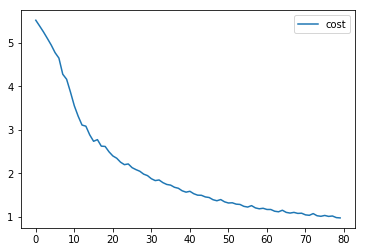

In [8]:
def main():
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount = True)
  
  train = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/train_32x32.mat')
  test = scipy.io.loadmat('/content/gdrive/My Drive/Colab Notebooks/Convolutional Neural Networks/test_32x32.mat')
  
  Xtrain = train['X']
  Ytrain = train['y']
  #print(Xtrain.shape)           (32, 32, 3, 73257)
  #print(Ytrain.shape)           (73257, 1)
  Ytrain = Ytrain.flatten() - 1
  
  Xtest = test['X']
  Ytest = test['y']
  #print(Xtest.shape)            (32, 32, 3, 26032)
  #print(Ytest.shape)            (26032, 1)
  Ytest = Ytest.flatten() - 1
  
  Xtrain = (Xtrain.transpose(3,0,1,2) / 255).astype(np.float32)
  Xtest = (Xtest.transpose(3,0,1,2) / 255).astype(np.float32)
  
  model = CNN(500)
  session = tf.InteractiveSession()
  model.set_session(session)
  model.fit(Xtrain, Ytrain, Xtest, Ytest)
  
if __name__ == '__main__':
  main()